In this python notebook I've tried to build a weather prediction model based on the dataset that contains a century of historical averages of global temperatures, including global maximum temperatures, global minimum temperatures, and global land and ocean temperatures. I've used supervised regression machine learning method for building up this model. The dataset was collected from Kaggle.

In [17]:
# Read the dataset
import pandas as pd
global_temp = pd.read_csv("GlobalTemperatures.csv")
print(global_temp.shape)
print(global_temp.columns)
print(global_temp.info())
print(global_temp.isnull().sum())


(3192, 9)
Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   

I’ll create a function called wrangle () in which I’ll call the dataframe.

I want to make a copy of the dataframe so as not to corrupt the original. After that, I'm going to remove the columns that have high cardinality.

High cardinality refers to columns whose values are very rare or unique. Given the frequency of high cardinality data in most time-series datasets, I'll solve this problem directly by completely removing these high cardinality columns from the dataset so as not to confuse the model in the future. 

Now, I will create a function to convert temperature, and to convert the columns into DateTime object---

In [18]:
#Data Preparation
def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)
    def converttemp(x):
        x = (x * 1.8) + 32
        return float(x)
    
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)
    df["dt"] = pd.to_datetime(df["dt"])
    df["Month"] = df["dt"].dt.month
    df["Year"] = df["dt"].dt.year
    df = df.drop("dt", axis=1)
    df = df.drop("Month", axis=1)
    df = df[df.Year >= 1850]
    df = df.set_index(["Year"])
    df = df.dropna()
    return df
global_temp = wrangle(global_temp)
print(global_temp.head())


      LandAverageTemperature  LandMaxTemperature  LandMinTemperature  \
Year                                                                   
1850                 33.3482             46.8356             26.2292   
1850                 37.5278             49.9460             27.8762   
1850                 40.9172             50.6246             28.5710   
1850                 44.9906             55.2812             33.8324   
1850                 50.0072             60.1790             38.8598   

      LandAndOceanAverageTemperature  
Year                                  
1850                         55.0994  
1850                         56.4584  
1850                         57.2774  
1850                         58.4006  
1850                         59.9126  


After calling the wrangle function to the global_temp dataframe, I can now see a new cleaned-up version of the global_temp dataframe with no missing values.

Visualization

Now, before moving forward with training a model to predict weather with machine learning, let’s visualize this data to find correlations between the data---


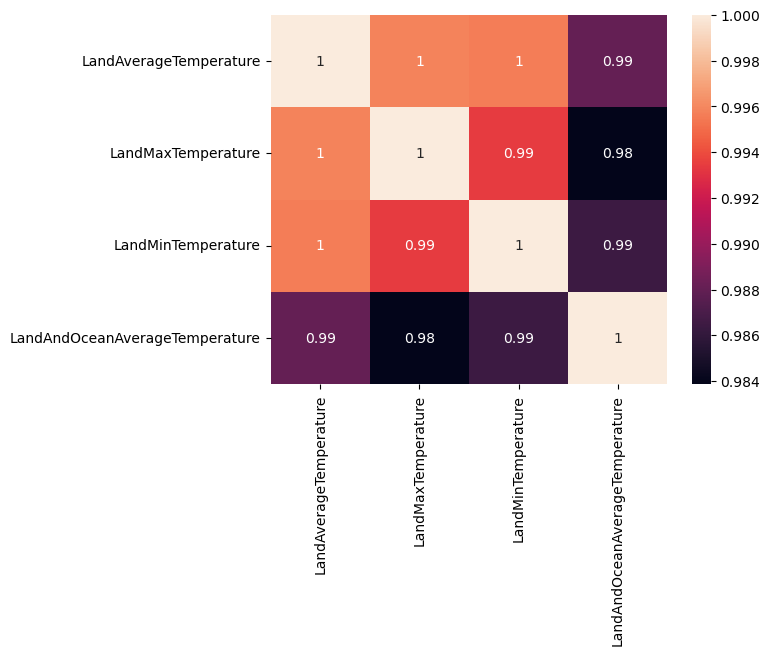

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

The columns that I've chosen to keep moving forward are highly correlated with each other.

Separating Target---

Now I need to separate the data into features and targets. The target, also called Y, is the value I want to predict, in this case, the actual average land and ocean temperature and features are all the columns the model uses to make a prediction.

In [20]:
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
x = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

Train Test Split

Now, to create a model to predict weather with machine learning we need to split the data by using the train_test_split method provided by scikit-learn---

In [50]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.25, random_state=42)
print(xtrain.shape)
print(xval.shape)
print(ytrain.shape)
print(yval.shape)

(1494, 3)
(498, 3)
(1494,)
(498,)


Baseline Mean Absolute Error

Before I can make and evaluate any predictions on my machine learning model to predict weather, I need to establish a baseline, a sane metric that I hope to beat with my model. If the model cannot improve from the baseline then it will fail and I should try a different model or admit that machine learning is not suitable for the problem.

In [51]:
from sklearn.metrics import mean_squared_error
ypred = [ytrain.mean()] * len(ytrain)
print("Baseline MAE: ", round(mean_squared_error(ytrain, ypred), 5))

Baseline MAE:  5.29374


Training Model To Predict Weather

Now to predict weather with Machine Learning I will train a Random Forest algorithm which is capable of performing both the tasks of Classification as well as Regression.

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)
forest.fit(xtrain, ytrain)

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

Model Evaluation---

To put my predictions in perspective, I can calculate a precision using the average percentage error subtracted from 100%.

In [58]:
import numpy as np
errors = abs(ytrain - yval)
mape = 100 * (errors/ytrain)
accuracy = 100 - np.mean(mape)
print("Random Forest Model: ", round(accuracy, 2), "%")

Random Forest Model:  95.28 %


The model has learned to predict weather conditions with machine learning for next year with 95% accuracy